# Example 3: Learning battery manufacturing data
## SI Section 2.5: 4-input 1-output battery manufacturing data
### Reference: 
### INN paper https://arxiv.org/abs/2404.10296 
### Data source https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/batt.201900135
Cunha, R.P., Lombardo, T., Primo, E.N. and Franco, A.A., 2020. Artificial intelligence investigation of NMC cathode manufacturing parameters interdependencies. Batteries & Supercaps, 3(1), pp.60-67.

In this example, we fit a 4-input 1-output battery manufacturing data available from Cunha et al., (2020). 

The 4 inputs are:
* $x_1$: active material mass content (%)
* $x_2$: solid-to-liquid ratio (%)
* $x_3$: comma gap (um)
* $x_4$: viscosity (Pa $\cdot$ s)

The 1 output is:
* $u$: active material mass loading (mg $\cdot$ ${cm}^{-2}$)

656 experimental data points are available via: https://drive.google.com/file/d/1QXpYlgqRBavjl_KMWQSHZRbhJt1F_v8g/view?usp=drive_link

The first step is to import the pyinn package.

In [ ]:
from jax import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)
import os, sys
import yaml
import importlib

from pyinn import dataset_classification, dataset_regression, model, train, plot # with pyinn library


<module 'plot' from '/home/cpm1402/pyinn/tutorials/../pyinn/plot.py'>

Next, we download the dataset and store it in /data directory in the current folder. The created datafile will be named as data_name = "cunha_battery_data.csv"

** Note
gdown is a Python package that allows you to download files from Google Drive using a URL.
It is useful for programmatically downloading datasets or files shared via Google Drive.

To install gdown, run the following command in a Jupyter notebook cell or your terminal:
!pip install gdown

First, set up GPUs

In [12]:
gpu_idx = 2  # set which GPU to run on Athena
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # GPU indexing
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)  # GPU indexing

In [13]:
!pip install gdown

/home/cpm1402/anaconda3/envs/pyinn-env/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [14]:
import gdown

# Create /data folder if it does not exist
folder_path = './data'
os.makedirs(folder_path, exist_ok=True)

# Download the dataset
url = "https://drive.google.com/uc?id=1QXpYlgqRBavjl_KMWQSHZRbhJt1F_v8g"
output_path = os.path.join(folder_path, "cunha_battery_data.csv")
gdown.download(url, output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1QXpYlgqRBavjl_KMWQSHZRbhJt1F_v8g
To: /home/cpm1402/pyinn/tutorials/data/cunha_battery_data.csv
100%|██████████| 32.0k/32.0k [00:00<00:00, 1.52MB/s]


'./data/cunha_battery_data.csv'

Then we import the data and setup the configuration.

In [15]:
# Define configuration of the dataset & training
data_name = 'cunha_battery_data' # data file name in /data directory
config = {}
config["DATA_PARAM"] = {
    "data_name": data_name,  # name of the dataset
    "data_filenames": [data_name+'.csv'],  # original data
    "input_col": [0,1,2,3],
    "output_col": [4],

    "bool_data_generation": False,  # we will import the data
    "split_ratio": [0.8, 0.1, 0.1],  # [0.7,0.15,0.15]

    "bool_normalize": True,  # whether we normalize the input data or not
    "bool_shuffle": True  # whether we shuffle the data
}
config["TRAIN_PARAM"] = {
    "num_epochs_INN": 300, # number of epochs for training the MLP
    "num_epochs_MLP": 300, # number of epochs for training the MLP
    "batch_size": 128,
    "learning_rate": 1e-3,
    "bool_train_acc": True,

    "validation_period": 1,
    "bool_denormalize": False,  # or True, whether we denormalize when measuring errors
    "error_type": "rmse",  # rmse or mse
    "patience": 5
}

# Create dataset and save it in /data directory
data = dataset_regression.Data_regression(data_name, config)
  

loaded 656 datapoints from cunha_battery_data dataset


Let us visualize the dataset

In [16]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(f'./data/{data_name}.csv')

# Display the first few rows
df.head()

,Composition,Solid to Liquid Ratio,Comma gap,Viscosity,Mass loading,Porosity
0,96.0,73.291013,50,3.1,7.508698,56.633408
1,96.0,73.291013,50,3.1,7.579602,57.261251
2,96.0,73.291013,50,3.1,6.941469,57.971229
3,96.0,73.291013,50,3.1,7.437795,53.910625
4,96.0,73.291013,50,3.1,7.225084,56.254016


The datafile contains columns: x1 (composition), x2 (solid to liquid ratio), x3 (comma gap), x4 (viscosity), u1 (mass loading), u2 (porosity, this will be neglected). This is the reason why we set the input_col = [0,1,2,3] and the output_col = [4].
Next, we define INN hyperparameters. A user need to define the following hyperparameters:

* nmode: number of modes; integer

The nubmer of tesnor decomposition (TD) modes. 

In the current problem, we set nmode = 10

* nseg: number of segments for each dimension; integer or a list of integers

This hyperparameter determines the grid resolution of an INN model. 

In the current problem, we set nseg = 20 (i.e., 21 grid points).

* s_patch; integer, 0 <= s_patch < nseg/2

The s_patch determines the number of neighboring segments to be employed for constructing INN interpolation functions. This integer variable should be less than half of the number of segments. Since this hyperparameter controls the support size of INN interpolation functions, a user can draw an educated decision depending on the nature of the problem. For instance, if a solution is expected to fluctuate locally, a small s_patch might be the right choice. 

It is important to note that when s_ptach == 0, the INN message passing Q is set as 1. That is, the linear interpolation functions will be constructed. If s_patch > 0, the INN message passing Q will become 2 and nonlinear interpolation functions will be constructed.

In the current problem, we set s_patch = 2 to match with the benchmarks discussed in Table S4.

* INN activation; string

This hyperparameter is activated when the INN interpolation functions are nonlinear (Q=2). The choices of the INN activation function can be found in Table S3: polynomial, sinusoidal, exponential, sigmoid, tanh, and GELU.

In the current problem, we set "polynomial" to match with the benchamrks discussed in Table S4.

* p_order; integer, p_order <= s_patch

This hyperparameter determines the number of INN activation functions to be incorporated. This corresponds to the variable "P" in Table S3. For instance, when the INN activation is "polynomial" and p_order = 2, the following activation functions will be included during the construction of the INN interpolation functions and the resulting INN interpolation functions will be able to exactly reproduce those INN activation functions:

\begin{gathered}
\begin{bmatrix}
\mathcal{A}_0(x) = 1 \\
\mathcal{A}_1(x) = x \\
\mathcal{A}_2(x) = x^2
\end{bmatrix}.
\end{gathered}

In the current problem, we set p_order = 2 to match with the benchmarks discussed in Table S4.

In [17]:
config["MODEL_PARAM"] = {
    "nmode": 10,
    "nseg": 20,
    "s_patch": 2,
    "INNactivation": "polynomial", # INN activation function, can be 'polynomial', 'sinusoidal', 'exponential', 'sigmoid', 'tanh', 'gelu'
    "p_order": 2,
    ### non-adjustable parameters
    "radial_basis": "cubicSpline",
    "alpha_dil": 20 # this is a dilation parameter and will be set as 20 for default.
}

Let's finalize the configuration file.

In [18]:
if config["MODEL_PARAM"]["s_patch"] > 0:
    config['interp_method'] = "nonlinear" # nonlinear (Q=2 INN message passing) interpolation
elif config["MODEL_PARAM"]["s_patch"] == 0:
    config['interp_method'] = "linear" # linear (Q=1 INN message passing) interpolation
config['TD_type'] = "CP"

Train INN (Q=2 nonlinear interpolation)

In [19]:
regressor = train.Regression_INN(data, config)  
regressor.train()  # Train module
params = regressor.params
errors_train, errors_val, error_test, errors_epoch = regressor.errors_train, regressor.errors_val, regressor.error_test, regressor.errors_epoch


edex_max / ndex_max: 6 / 5
------------ INN CP nonlinear, nmode: 10, nseg: 20, s=2, P=2 -------------
# of training parameters: 840
Epoch 1
	Train rmse: 4.9889e-01
	Val RMSE: 4.6802e-01
	1.47 seconds per epoch
Epoch 2
	Train rmse: 4.7886e-01
	Val RMSE: 4.5072e-01
	0.74 seconds per epoch
Epoch 3
	Train rmse: 4.6006e-01
	Val RMSE: 4.3493e-01
	0.50 seconds per epoch
Epoch 4
	Train rmse: 4.4233e-01
	Val RMSE: 4.2031e-01
	0.38 seconds per epoch
Epoch 5
	Train rmse: 4.2640e-01
	Val RMSE: 4.0655e-01
	0.31 seconds per epoch
Epoch 6
	Train rmse: 4.1106e-01
	Val RMSE: 3.9353e-01
	0.26 seconds per epoch
Epoch 7
	Train rmse: 3.9661e-01
	Val RMSE: 3.8120e-01
	0.22 seconds per epoch
Epoch 8
	Train rmse: 3.8300e-01
	Val RMSE: 3.6971e-01
	0.20 seconds per epoch
Epoch 9
	Train rmse: 3.7073e-01
	Val RMSE: 3.5908e-01
	0.18 seconds per epoch
Epoch 10
	Train rmse: 3.5895e-01
	Val RMSE: 3.4920e-01
	0.16 seconds per epoch
Epoch 11
	Train rmse: 3.4762e-01
	Val RMSE: 3.4002e-01
	0.15 seconds per epoch
Epoch 12

Plot loss history

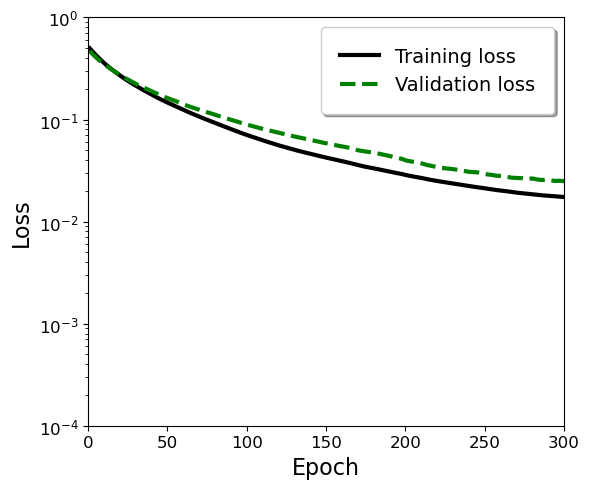

In [20]:
config["PLOT"] = {"bool_plot": True,
                  "plot_in_axis": [0, 1, 2, 3],  # plot input axis
                  "plot_out_axis": [4]}  # plot output axis
plot.plot_regression(regressor, data, config)

### Effect of Hyperparameter - INN activation

Now, let's study the effect of the hyperparameter, INN activation. The vailable INN activation functions are: 

* polynomial
* sinusoidal
* exponential
* sigmoid
* tanh
* GELU

We will run the same trainng task and see how those INN activation functions affect test accuracy for this realistic experimental data.

In [21]:
import numpy as np
INNactivations = ['polynomial', 'sinusoidal', 'exponential', 'sigmoid', 'tanh', 'gelu']
random_cases = 1 # number of random cases to run for each activation function, this was set as 10 in the Supplementary Information.

errors_test = np.zeros((random_cases, len(INNactivations)))
for j, INNactivation in enumerate(INNactivations):
    for i in range(random_cases):
        print(f"Running case {i+1} with activation: {INNactivation}")

        # update configuration
        config["MODEL_PARAM"]["INNactivation"] = INNactivation

        # train INN
        regressor = train.Regression_INN(data, config)  
        regressor.train()  # Train module
        params = regressor.params
        errors_train, errors_val, error_test, errors_epoch = regressor.errors_train, regressor.errors_val, regressor.error_test, regressor.errors_epoch

        print(f"Activation: {INNactivation}, Test Error: {error_test}")
        errors_test[i, j] = error_test


Running case 1 with activation: polynomial
edex_max / ndex_max: 6 / 5
------------ INN CP nonlinear, nmode: 10, nseg: 20, s=2, P=2 -------------
# of training parameters: 840
Epoch 1
	Train rmse: 3.4137e-01
	Val RMSE: 3.4376e-01
	1.79 seconds per epoch
Epoch 2
	Train rmse: 3.2975e-01
	Val RMSE: 3.3442e-01
	0.90 seconds per epoch
Epoch 3
	Train rmse: 3.1915e-01
	Val RMSE: 3.2560e-01
	0.61 seconds per epoch
Epoch 4
	Train rmse: 3.0946e-01
	Val RMSE: 3.1759e-01
	0.46 seconds per epoch
Epoch 5
	Train rmse: 3.0005e-01
	Val RMSE: 3.0990e-01
	0.37 seconds per epoch
Epoch 6
	Train rmse: 2.9157e-01
	Val RMSE: 3.0237e-01
	0.31 seconds per epoch
Epoch 7
	Train rmse: 2.8309e-01
	Val RMSE: 2.9470e-01
	0.27 seconds per epoch
Epoch 8
	Train rmse: 2.7518e-01
	Val RMSE: 2.8729e-01
	0.24 seconds per epoch
Epoch 9
	Train rmse: 2.6713e-01
	Val RMSE: 2.8033e-01
	0.21 seconds per epoch
Epoch 10
	Train rmse: 2.5936e-01
	Val RMSE: 2.7380e-01
	0.19 seconds per epoch
Epoch 11
	Train rmse: 2.5202e-01
	Val RMSE: 

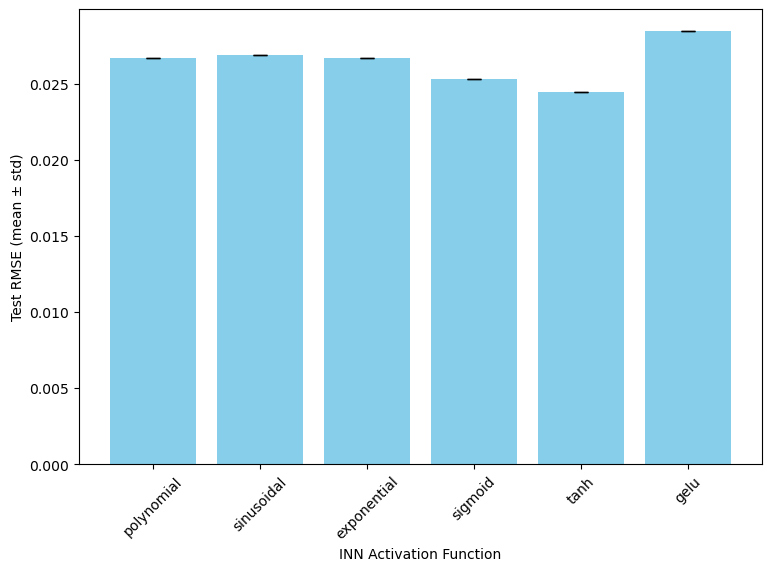

In [22]:
errors_test_mean = np.mean(errors_test, axis=0)
errors_test_std = np.std(errors_test, axis=0)

# Print the results
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(INNactivations, errors_test_mean, yerr=errors_test_std, capsize=5, color='skyblue')
plt.xticks(rotation=45)
plt.rcParams.update({'font.size': 16, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16})
plt.ylabel('Test RMSE (mean ± std)')
plt.xlabel('INN Activation Function')
# plt.title('Effect of INN Activation on Test RMSE Error')
plt.tight_layout()
plt.show()

### Comparison with MLPs

#### Case 1: MLP
* layers: 3
* neurons: 20
* activation: Sigmoid

In [23]:
# Configuration
config["MODEL_PARAM"] = {
    "nlayers": 3,
    "nneurons": 20,
    "activation": "sigmoid"
}
config['interp_method'] = "MLP"

Train MLP and plot loss history

------------ MLP, [4, 20, 20, 20, 1] -------------
# of training parameters: 961
Epoch 1
	Train rmse: 4.0893e-01
	Val RMSE: 3.5277e-01
	0.89 seconds per epoch
Epoch 2
	Train rmse: 3.1801e-01
	Val RMSE: 2.8049e-01
	0.45 seconds per epoch
Epoch 3
	Train rmse: 2.8430e-01
	Val RMSE: 2.6269e-01
	0.30 seconds per epoch
Epoch 4
	Train rmse: 2.8963e-01
	Val RMSE: 2.6473e-01
	0.23 seconds per epoch
Epoch 5
	Train rmse: 2.9613e-01
	Val RMSE: 2.6388e-01
	0.18 seconds per epoch
Epoch 6
	Train rmse: 2.9085e-01
	Val RMSE: 2.5885e-01
	0.16 seconds per epoch
Epoch 7
	Train rmse: 2.8007e-01
	Val RMSE: 2.6073e-01
	0.13 seconds per epoch
Epoch 8
	Train rmse: 2.7568e-01
	Val RMSE: 2.6791e-01
	0.12 seconds per epoch
Epoch 9
	Train rmse: 2.7631e-01
	Val RMSE: 2.6782e-01
	0.11 seconds per epoch
Epoch 10
	Train rmse: 2.7416e-01
	Val RMSE: 2.5952e-01
	0.10 seconds per epoch
Epoch 11
	Train rmse: 2.7040e-01
	Val RMSE: 2.5329e-01
	0.09 seconds per epoch
Epoch 12
	Train rmse: 2.6873e-01
	Val RMSE: 2.5059e-01
	0.0

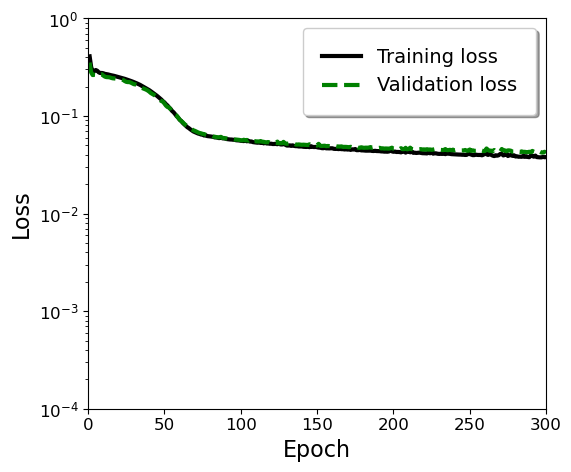

In [24]:
regressor = train.Regression_MLP(data, config) 
regressor.train()  # Train module

config["PLOT"] = {"bool_plot": True,
                  "plot_in_axis": [0, 1, 2, 3],  # plot input axis
                  "plot_out_axis": [4]}  # plot output axis
plot.plot_regression(regressor, data, config)

#### Case 2: PGD (INN with TD and Q=1 linear interpolation)
* nmode: 10
* nseg: 20
* s_patch: 0 (i.e., Q=1 linear interpolation) -> PGD

In [25]:
# Configuration
config["MODEL_PARAM"] = {
    "nmode": 10,
    "nseg": 20,
    "s_patch": 0,
    # "p_order": 2,
    # "radial_basis": "cubicSpline",
    # "INNactivation": "polynomial", # INN activation function, can be 'polynomial', 'sinusoidal', 'exponential', 'sigmoid', 'tanh', 'gelu'
    # "alpha_dil": 20 # this is a dilation parameter and will be set as 20 for default.
}
if config["MODEL_PARAM"]["s_patch"] > 0:
    config['interp_method'] = "nonlinear" # nonlinear (Q=2 INN message passing) interpolation
elif config["MODEL_PARAM"]["s_patch"] == 0:
    config['interp_method'] = "linear" # linear (Q=1 INN message passing) interpolation
config['TD_type'] = "CP"

Train INN and plot loss history

------------ INN CP linear, nmode: 10, nseg: 20 -------------
# of training parameters: 840
Epoch 1
	Train rmse: 4.0078e-01
	Val RMSE: 3.4273e-01
	0.80 seconds per epoch
Epoch 2
	Train rmse: 3.8083e-01
	Val RMSE: 3.2742e-01
	0.41 seconds per epoch
Epoch 3
	Train rmse: 3.6319e-01
	Val RMSE: 3.1352e-01
	0.27 seconds per epoch
Epoch 4
	Train rmse: 3.4712e-01
	Val RMSE: 3.0075e-01
	0.21 seconds per epoch
Epoch 5
	Train rmse: 3.3216e-01
	Val RMSE: 2.8922e-01
	0.17 seconds per epoch
Epoch 6
	Train rmse: 3.1846e-01
	Val RMSE: 2.7921e-01
	0.14 seconds per epoch
Epoch 7
	Train rmse: 3.0638e-01
	Val RMSE: 2.7012e-01
	0.12 seconds per epoch
Epoch 8
	Train rmse: 2.9500e-01
	Val RMSE: 2.6181e-01
	0.11 seconds per epoch
Epoch 9
	Train rmse: 2.8490e-01
	Val RMSE: 2.5422e-01
	0.10 seconds per epoch
Epoch 10
	Train rmse: 2.7539e-01
	Val RMSE: 2.4687e-01
	0.09 seconds per epoch
Epoch 11
	Train rmse: 2.6672e-01
	Val RMSE: 2.4051e-01
	0.08 seconds per epoch
Epoch 12
	Train rmse: 2.5883e-01
	Val RMSE: 2.34

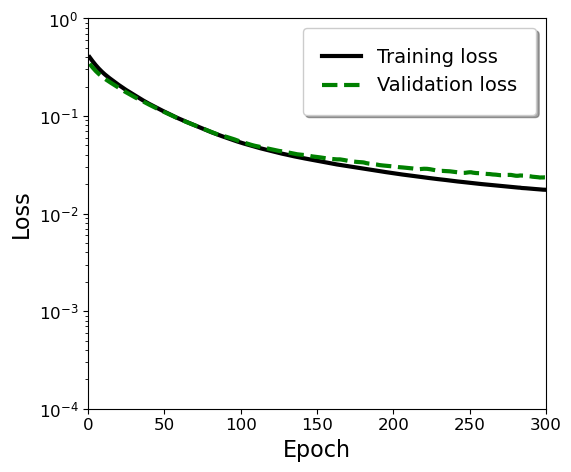

In [26]:
regressor = train.Regression_INN(data, config)  
regressor.train()  # Train module

config["PLOT"] = {"bool_plot": True,
                  "plot_in_axis": [0, 1, 2, 3],  # plot input axis
                  "plot_out_axis": [4]}  # plot output axis
plot.plot_regression(regressor, data, config)

#### Case 3: INN (Q=2)
* nmode: 10
* nseg: 20
* INN activation: polynomial
* s_patch: 2
* p_order: 2


In [27]:
# Configuration
config["MODEL_PARAM"] = {
    "nmode": 10,
    "nseg": 20,
    "s_patch": 2,
    "INNactivation": "polynomial", # INN activation function, can be 'polynomial', 'sinusoidal', 'exponential', 'sigmoid', 'tanh', 'gelu'
    "p_order": 2,
    ### non-adjustable parameters
    "radial_basis": "cubicSpline",
    "alpha_dil": 20 # this is a dilation parameter and will be set as 20 for default.
}
if config["MODEL_PARAM"]["s_patch"] > 0:
    config['interp_method'] = "nonlinear" # nonlinear (Q=2 INN message passing) interpolation
elif config["MODEL_PARAM"]["s_patch"] == 0:
    config['interp_method'] = "linear" # linear (Q=1 INN message passing) interpolation
config['TD_type'] = "CP"

Train INN and plot loss history

edex_max / ndex_max: 6 / 5
------------ INN CP nonlinear, nmode: 10, nseg: 20, s=2, P=2 -------------
# of training parameters: 840
Epoch 1
	Train rmse: 4.0987e-01
	Val RMSE: 3.6488e-01
	1.49 seconds per epoch
Epoch 2
	Train rmse: 3.9268e-01
	Val RMSE: 3.5155e-01
	0.75 seconds per epoch
Epoch 3
	Train rmse: 3.7724e-01
	Val RMSE: 3.3932e-01
	0.51 seconds per epoch
Epoch 4
	Train rmse: 3.6275e-01
	Val RMSE: 3.2818e-01
	0.38 seconds per epoch
Epoch 5
	Train rmse: 3.4955e-01
	Val RMSE: 3.1786e-01
	0.31 seconds per epoch
Epoch 6
	Train rmse: 3.3740e-01
	Val RMSE: 3.0793e-01
	0.26 seconds per epoch
Epoch 7
	Train rmse: 3.2601e-01
	Val RMSE: 2.9878e-01
	0.23 seconds per epoch
Epoch 8
	Train rmse: 3.1526e-01
	Val RMSE: 2.9037e-01
	0.20 seconds per epoch
Epoch 9
	Train rmse: 3.0529e-01
	Val RMSE: 2.8267e-01
	0.18 seconds per epoch
Epoch 10
	Train rmse: 2.9629e-01
	Val RMSE: 2.7526e-01
	0.16 seconds per epoch
Epoch 11
	Train rmse: 2.8735e-01
	Val RMSE: 2.6819e-01
	0.15 seconds per epoch
Epoch 12

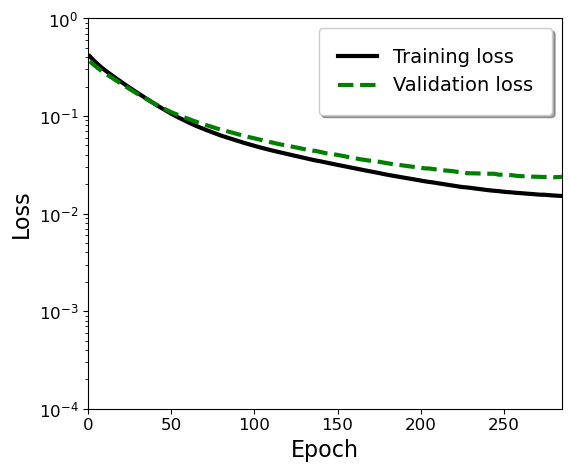

In [28]:
regressor = train.Regression_INN(data, config)  
regressor.train()  # Train module

config["PLOT"] = {"bool_plot": True,
                  "plot_in_axis": [0, 1, 2, 3],  # plot input axis
                  "plot_out_axis": [4]}  # plot output axis
plot.plot_regression(regressor, data, config)